In [27]:
NAMES = ["Andrew Fidler",
         "Ryan Da Silva",
         "Mike Suderman",
         "Pavel Demin",
         "Saewan Koh",
         ]
GROUP = "4"
# link to data: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410037601&pickMembers%5B0%5D=1.7&pickMembers%5B1%5D=2.1&cubeTimeFrame.startMonth=10&cubeTimeFrame.startYear=2011&cubeTimeFrame.endMonth=02&cubeTimeFrame.endYear=2023&referencePeriods=20111001%2C20230201

In [28]:
import pandas as pd
# from pathlib import Path
# import numpy as np
import matplotlib.pyplot as plt
# import scipy.stats as ss
import statsmodels.api as sm




In [29]:
# read data
on_df = pd.read_csv('1410037601_databaseLoadingData.csv')

# drop redundant columns
on_df = on_df[[
    'REF_DATE',
    'Class of worker',
    'North American Industry Classification System (NAICS)',
    'VALUE',
    'STATUS'
]]
# convert date column
on_df.REF_DATE = on_df.REF_DATE.astype('datetime64')

print(on_df.head())


    REF_DATE                         Class of worker  \
0 2011-10-01  Total employed, all classes of workers   
1 2011-11-01  Total employed, all classes of workers   
2 2011-12-01  Total employed, all classes of workers   
3 2012-01-01  Total employed, all classes of workers   
4 2012-02-01  Total employed, all classes of workers   

  North American Industry Classification System (NAICS)   VALUE STATUS  
0                     Total employed, all industries     6659.9    NaN  
1                     Total employed, all industries     6678.5    NaN  
2                     Total employed, all industries     6649.4    NaN  
3                     Total employed, all industries     6550.1    NaN  
4                     Total employed, all industries     6545.7    NaN  


In [30]:
# pivot table to show collected values
DF_PIVOT = on_df.pivot(index=["REF_DATE"], 
            columns=["Class of worker", "North American Industry Classification System (NAICS)"],
            values="VALUE")

DF_PIVOT

Class of worker                                       Total employed, all classes of workers  \
North American Industry Classification System (NAICS)         Total employed, all industries   
REF_DATE                                                                                       
2011-10-01                                                                            6659.9   
2011-11-01                                                                            6678.5   
2011-12-01                                                                            6649.4   
2012-01-01                                                                            6550.1   
2012-02-01                                                                            6545.7   
...                                                                                      ...   
2022-10-01                                                                            7755.8   
2022-11-01                                                                            7778.4   
2022-12-01                                                                            7797.4   
2023-01-01                                                                            7754.1   
2023-02-01                                                                            7790.1   

Class of worker                                                               \
North American Industry Classification System (NAICS) Goods-producing sector   
REF_DATE                                                                       
2011-10-01                                                            1428.5   
2011-11-01                                                            1419.4   
2011-12-01                                                            1388.6   
2012-01-01                                                            1364.8   
2012-02-01                                                            1360.8   
...                                                                      ...   
2022-10-01                                                            1561.3   
2022-11-01                                                            1564.2   
2022-12-01                                                            1552.7   
2023-01-01                                                            1522.0   
2023-02-01                                                            1529.9   

Class of worker                                                                               \
North American Industry Classification System (NAICS) Agriculture [111-112, 1100, 1151-1152]   
REF_DATE                                                                                       
2011-10-01                                                                              84.7   
2011-11-01                                                                              84.7   
2011-12-01                                                                              81.5   
2012-01-01                                                                              78.6   
2012-02-01                                                                              77.1   
...                                                                                      ...   
2022-10-01                                                                              72.6   
2022-11-01                                                                              75.0   
2022-12-01                                                                              78.1   
2023-01-01                                                                              73.4   
2023-02-01                                                                              71.9   

Class of worker                                                                                                                    \
North American Industry Classification System (NAICS) Fo

Text(0, 0.5, 'total (1000s)')

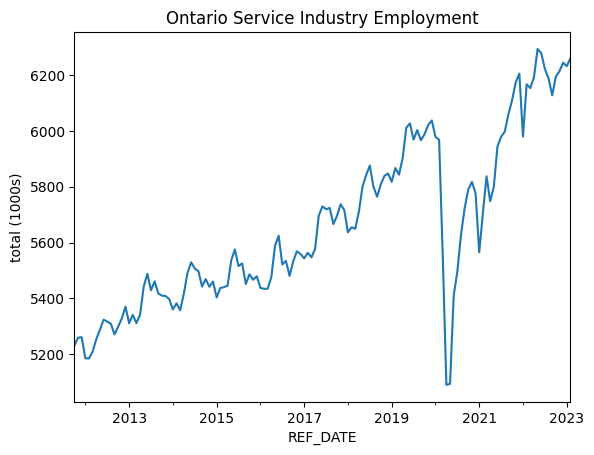

In [31]:
# just looking at all Service workers, regardless of sub-industry, self-employed status  
service_col = DF_PIVOT['Total employed, all classes of workers','Services-producing sector'].copy()
gr = service_col.plot.line(title='Ontario Service Industry Employment')
gr.set_ylabel("total (1000s)")

# we can see the seasonality and the enormous drop during the first few months of Covid
# interestingly, we can also see the quick recovery and continued upward trend

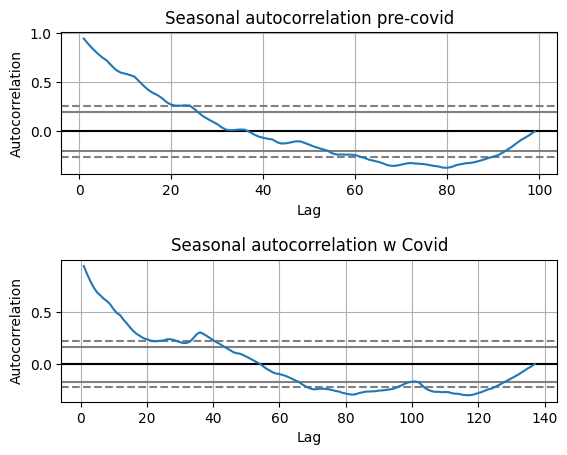

In [32]:
# need to review and clean autocorelation (seasonality)
from statsmodels.graphics import tsaplots

service_col_precovid = service_col[:"2019-12-31 00:00:00"].copy()

fig, (ax1, ax2) = plt.subplots(2, 1)
# plot the auto correlation
# ac = tsaplots.plot_acf(service_col[:'2019-12-31'])


ax1.set_title('Seasonal autocorrelation pre-covid')
pd.plotting.autocorrelation_plot(service_col_precovid, ax=ax1)

pd.plotting.autocorrelation_plot(service_col, ax=ax2)
ax2.set_title('Seasonal autocorrelation w Covid')

plt.subplots_adjust(hspace=.6)
plt.show()

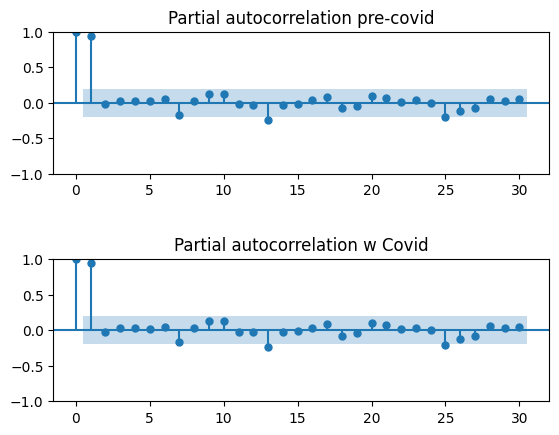

In [33]:
# check partial autocorrelation to avoid false positive
fig, (ax1, ax2) = plt.subplots(2, 1)


tsaplots.plot_pacf(
    service_col_precovid, 
    lags=30, 
    ax=ax1, 
    title='Partial autocorrelation pre-covid', 
    method='ywm'
    )

tsaplots.plot_pacf(
    service_col_precovid, 
    lags=30, 
    ax=ax2, 
    title='Partial autocorrelation w Covid', 
    method='ywm'
    )

plt.subplots_adjust(hspace=.6)
plt.show()
# RESULT: negative autocorrelation around 12 months for both, and 24 months when Covid is excluded
# month 3+1 = 4 should be used for the max lag for the model (first '0' + 1), but will try on 13 as well 

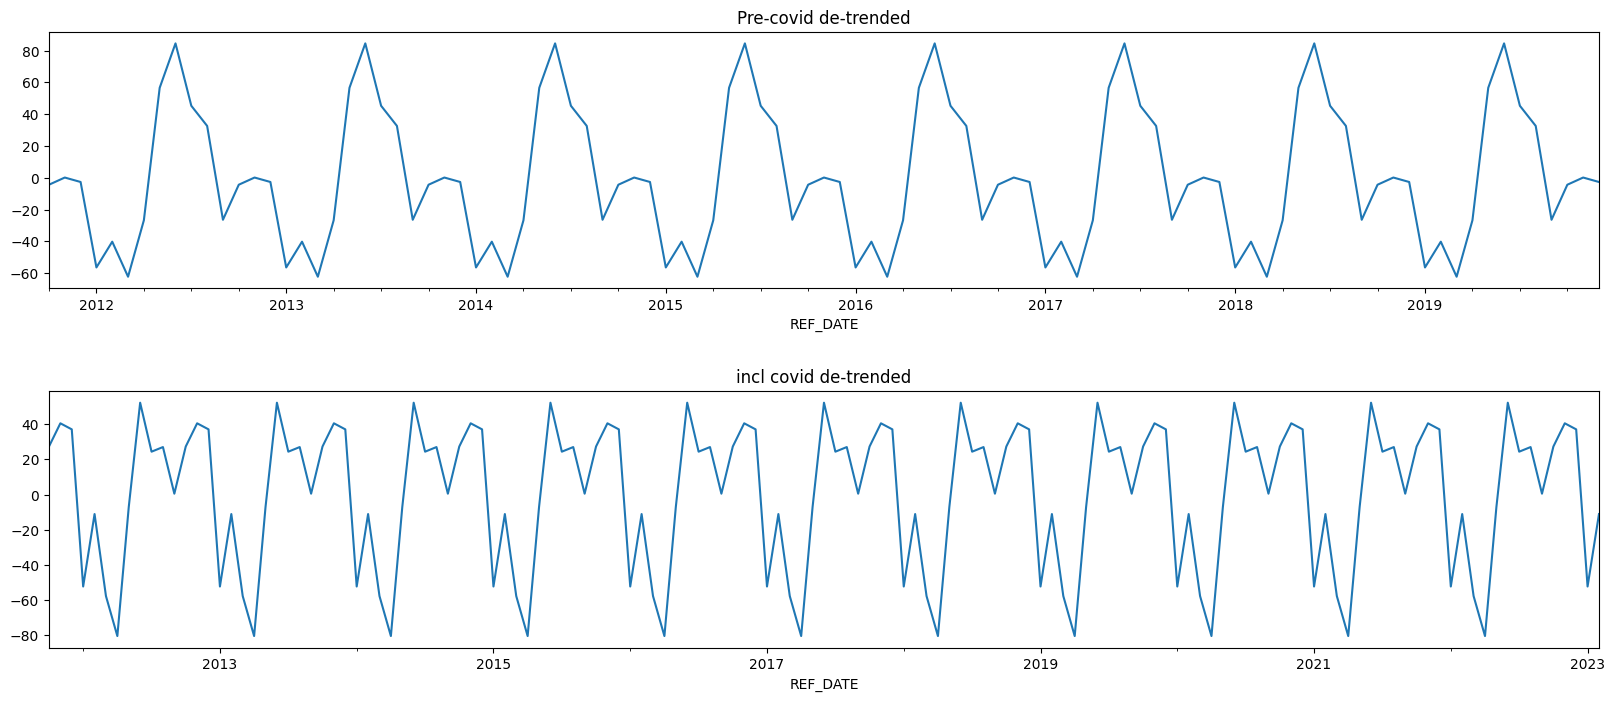

In [34]:
# Seasonality - pre-covid
decomp = sm.tsa.seasonal_decompose(service_col) 
precovid_decomp = sm.tsa.seasonal_decompose(service_col_precovid) 

fig, (ax1, ax2) = plt.subplots(2, 1)

precovid_decomp.seasonal.plot(figsize=(20, 8), title='Pre-covid de-trended', ax = ax1)
decomp.seasonal.plot(figsize=(20, 8), title='incl covid de-trended', ax = ax2)
plt.subplots_adjust(hspace=.4)
plt.show()


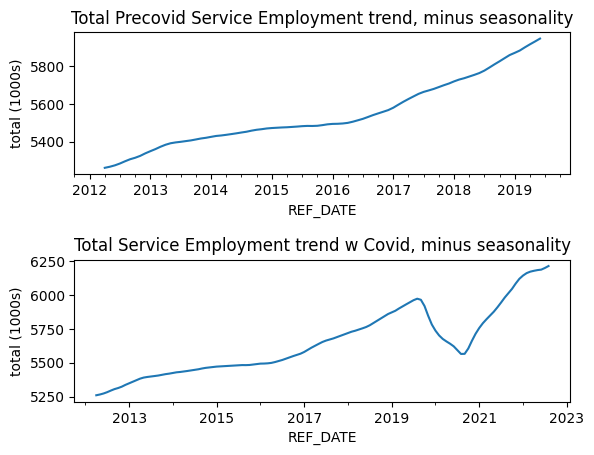

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1)

precovid_decomp.trend.plot(title='Total Precovid Service Employment trend, minus seasonality', ax = ax1)
ax1.set_ylabel("total (1000s)")

decomp.trend.plot(title='Total Service Employment trend w Covid, minus seasonality', ax = ax2)
ax2.set_ylabel("total (1000s)")

plt.subplots_adjust(hspace=.6)
plt.show()

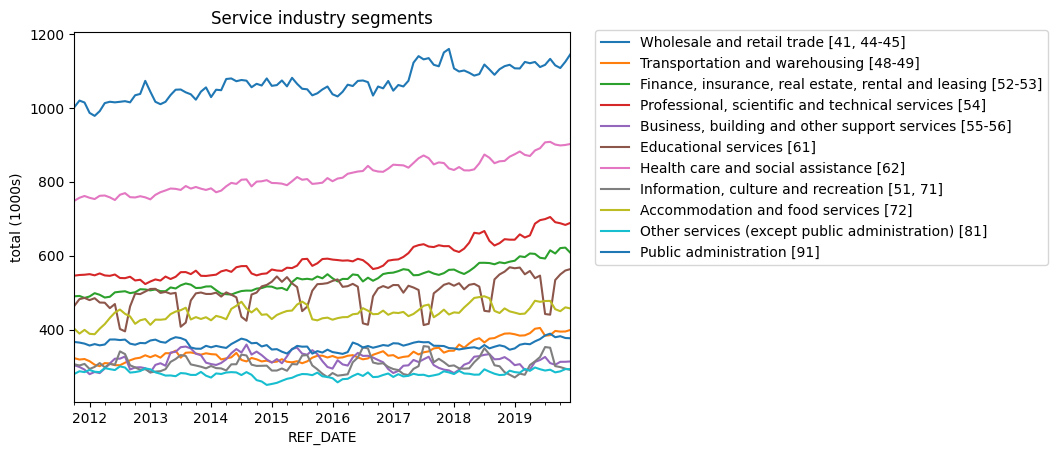

In [36]:
# Break down the pre-Service level using some specific segments, same process as above.

# looking at narrower segments:
SEGMENTS = [
    'Wholesale and retail trade [41, 44-45]',
    'Transportation and warehousing [48-49]',
    'Finance, insurance, real estate, rental and leasing [52-53]',
    'Professional, scientific and technical services [54]',
    'Business, building and other support services [55-56]',
    'Educational services [61]',
    'Health care and social assistance [62]',
    'Information, culture and recreation [51, 71]',
    'Accommodation and food services [72]',
    'Other services (except public administration) [81]',
    'Public administration [91]',
]
def plot_precovid(df: pd.DataFrame, col_names: list[str]):
    leg = []
    for col in col_names:
        seg_col_precovid = df['Total employed, all classes of workers',col][:"2019-12-31 00:00:00"].copy()
        gr = seg_col_precovid.plot.line(title=f'Service industry segments', legend=True)
        leg.append(col)
        gr.set_ylabel("total (1000s)")
    gr.legend(leg, loc=(1.05, .37))
    gr.plot()



def seasonal_decompose_precovid(df: pd.DataFrame, col_names: list[str]):
    for col in col_names[:1]:
        seg_col_precovid = df['Total employed, all classes of workers',col][:"2019-12-31 00:00:00"].copy()
        decomposition = sm.tsa.seasonal_decompose(seg_col_precovid)
        # gr = decomposition.seasonal.plot(figsize=(20, 8), title='Pre-covid Seasonal autocorrelation')
        gr = decomposition.trend.plot(title=f'{col}, minus seasonality')
        gr.set_ylabel("total (1000s)")
 
plot_precovid(DF_PIVOT, SEGMENTS)
# plot_seasonality_precovid(df_pivot, SEGMENTS)
# seasonal_decompose_precovid(df_pivot, SEGMENTS)

        

In [37]:
# TODO: 
# partial autocorrelation and verify 
# Review both methods of decompose (additive or multiplicative)

# Build model? Choose maximum lag for regression based on first '0' value in the partial autocorrelation, +1 (maybe 3-4 months?)
# try a log transform to remove some of the noise?

# Split before Covid, After Covid, including covid
# Pavel's data says that the rate of change after May returns to normal. So maybe start that line there?
# linear canyon regression (for taking care of coronavirus hole in data)

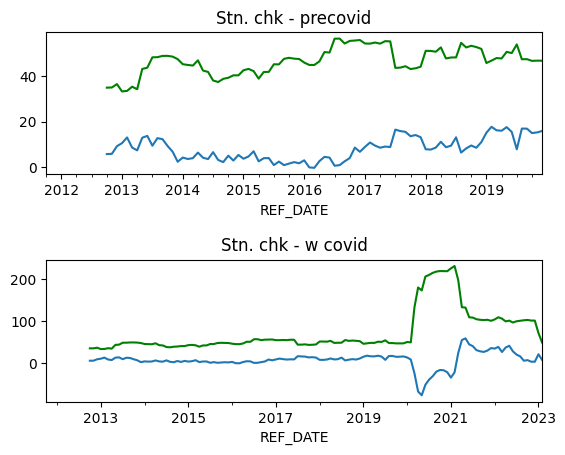

In [38]:
# checking for readiness to be used in an ARMA model, by checking stationery levels

fig, (ax1, ax2) = plt.subplots(2, 1)

service_col_precovid.diff().rolling(12).mean().plot(ax=ax1, title='Stn. chk - precovid')
service_col_precovid.diff().rolling(12).std().plot(ax=ax1, color='green')

service_col.diff().rolling(12).mean().plot(ax=ax2, title='Stn. chk - w covid')
service_col.diff().rolling(12).std().plot(ax=ax2, color='green')

plt.subplots_adjust(hspace=.6)
plt.show()

# pre-covid looks ok, but with Covid will need some cleaning.

<AxesSubplot: title={'center': 'Stn. chk - w covid (cleaner)'}, xlabel='REF_DATE'>

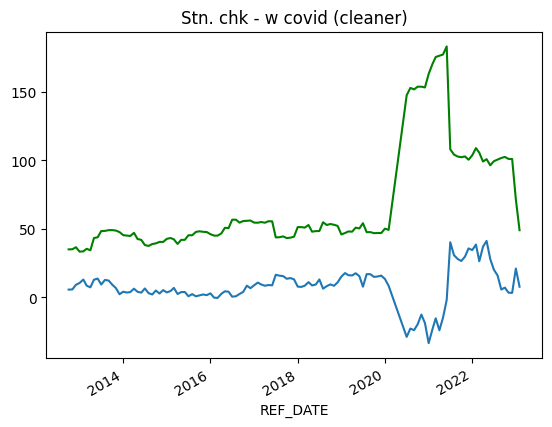

In [39]:
# Per the analysis done by Pavel, the major outliers are Mar-Jun of 2020. We will attempt to rerun without those values


service_col_clean = pd.concat([
    service_col[:'2020-02-29 00:00:00'].copy(), # all data to Feb 2020
    service_col['2020-07-01 00:00:00':].copy() # rest of data, skipping outliers Mar-Jun
])


# try again with the cleaner version
service_col_clean.diff().rolling(12).mean().plot(title='Stn. chk - w covid (cleaner)')
service_col_clean.diff().rolling(12).std().plot(color='green')

# still not great, but returns a little better.

In [40]:
# Building a model with the two sets of data, each split into test and train:

from statsmodels.tsa.arima.model import ARIMA

train_perc = 0.7 # training data will be 70% of the data available 

def split_train_and_test(s: pd.Series, perc: float) -> tuple[pd.Series]:
    n = int(len(s) * perc)
    return s.iloc[:n].copy(), s.iloc[n:].copy() # train, test

pre_cov_train, pre_cov_test = split_train_and_test(service_col_precovid, train_perc)
w_cov_train, w_cov_test = split_train_and_test(service_col_precovid, train_perc)



In [41]:
pre_cov_train = pre_cov_train.resample("M").last() # cleans up the dates so ARIMA reads it easier 
arima = ARIMA(pre_cov_train.astype(float), order=(3,3,1))
arima_fit = arima.fit()
print(arima_fit.summary())

                                                          SARIMAX Results                                                          
Dep. Variable:     ('Total employed, all classes of workers', 'Services-producing sector')   No. Observations:                   69
Model:                                                                      ARIMA(3, 3, 1)   Log Likelihood                -358.654
Date:                                                                     Fri, 31 Mar 2023   AIC                            727.309
Time:                                                                             23:44:18   BIC                            738.257
Sample:                                                                         10-31-2011   HQIC                           731.635
                                                                              - 06-30-2017                                         
Covariance Type:                                                            

<AxesSubplot: xlabel='REF_DATE'>

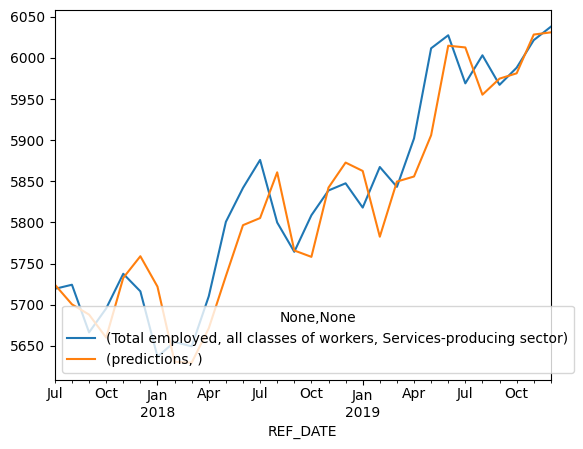

In [42]:
import numpy as np

# test the model against the real data, regardless of the rise in minimum wage, to validate

def run_prediction(train_data: pd.Series, test_data: pd.Series, order: tuple, feed_test_or_pred: str = 'test') -> pd.DataFrame:
    # TODO: lists are slow, maybe rewrite?

    # convert to lists to easily use append to accumulate results
    hist = list(train_data.copy())
    test = list(test_data.copy())
    pred = []
    
    for i in range(len(test)):
        # print(hist)
        # Initalize the model
        arima = ARIMA(hist, order=order)
        #Fit the model on the available history
        arima_fit = arima.fit()
        # add the prediction to the list
        pred.append(arima_fit.forecast())
        # expand the history
        # feed the prediction into the history
        if feed_test_or_pred == 'pred': 
            p = arima_fit.forecast()
            hist.append(float(p[()])) # empty tuple as index to grab value from 0d np.array
        # feed the true data into the history
        elif feed_test_or_pred == 'test': 
            hist.append(test[i])
        else:
            print('invalid value for feed_test_or_pred')
            return None
    # print(pred)

    pred = np.concatenate(pred)

    r = test_data.copy().to_frame()
    r['predictions'] = pred
    r['error'] = r.iloc[:, 0] - r.predictions
    

    return r

pre_covid_results = run_prediction(pre_cov_train, pre_cov_test, order=(6,1,0))

pre_covid_results.drop('error', axis=1).plot()


42.99440848292506


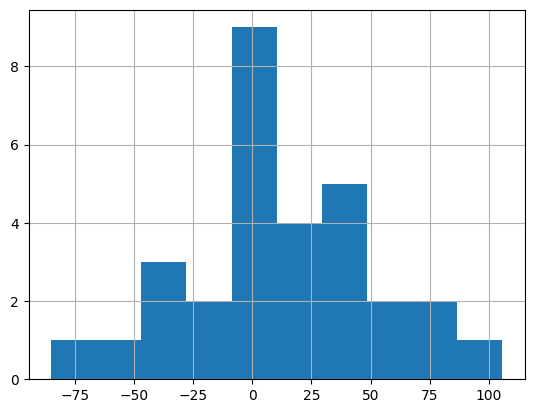

In [43]:
# error appears to be within acceptable limits.

pre_covid_results.error.hist()
rmse = np.sqrt(np.mean(np.square(pre_covid_results.error - np.mean(pre_covid_results.error))))
print (rmse)

In [44]:
# We will now create the predictions of the model, training it on all data prior to the 2018 increase in minimum wage
# we will use the predictions to grow the history, rather than feeding in the real numbers, 
# to see if the model expects higher employment than it receives

train_2018 = service_col[:'2017-12-31 00:00:00'].copy()
real_post_2018 = service_col['2018-01-01 00:00:00':].copy()

pred_2018 = run_prediction(train_2018, real_post_2018, order=(12,1,3), feed_test_or_pred='pred')
# we get a lot of Convergence warnings on this setup, but the results look like it succeeded

c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\U

<AxesSubplot: xlabel='REF_DATE'>

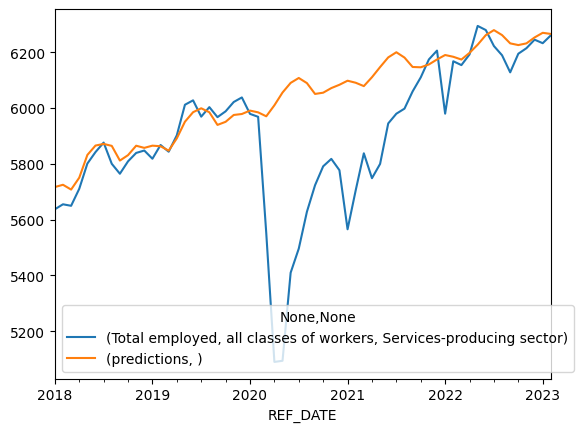

In [45]:
# plot it out

pred_2018.drop('error', axis=1).plot()

In [46]:
# Now we try the same technique, but with the Oct 2020 raise in minimum wage

train_2020 = service_col[:'2020-09-30 00:00:00'].copy()
real_post_2020 = service_col['2020-10-01 00:00:00':].copy()

# drop the 4 outlier months in 2020 that were identified by Pavel's analysis
train_2020 = pd.concat([
    train_2020[:'2020-02-29 00:00:00'].copy(), # all data to Feb 2020
    train_2020['2020-07-01 00:00:00':].copy() # rest of data, skipping outliers Mar-Jun
])

pred_2020 = run_prediction(train_2020, real_post_2020, order=(12,1,3), feed_test_or_pred='pred')


c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mikes\Programs\python-venvs\datascience\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opt

<AxesSubplot: xlabel='REF_DATE'>

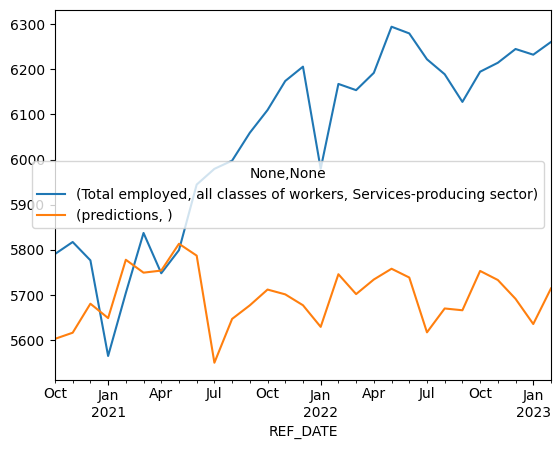

In [47]:
# plot it out

pred_2020.drop('error', axis=1).plot()

# really couldn't get this one close, not sure what to do, with it

[]

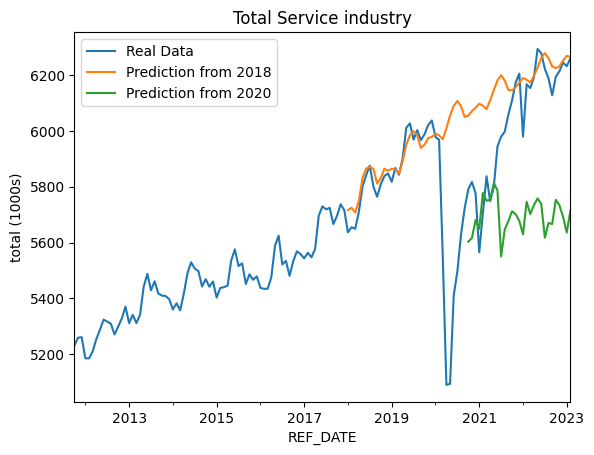

In [48]:
# combine the predicted datasets

df_total_service = service_col.copy().to_frame()
df_total_service['prediction_2018'] = pred_2018['predictions']
df_total_service['prediction_2020'] = pred_2020['predictions']

# graph

leg = []

gr = df_total_service.plot.line(title='Total Service industry', legend=True)
gr.legend(['Real Data', 'Prediction from 2018', 'Prediction from 2020'])
gr.set_ylabel("total (1000s)")
gr.plot()


In [54]:
# Above concludes my analysis of the column for the Service Industry as a whole.
# Below I will use the same process to examine the individual industry segments split out
# in the data set.

# first, some functions to keep things simpler
from datetime import datetime

def split_data(s: pd.Series, split_date: str) -> tuple[pd.Series]:
    t = s[:split_date].copy()
    r = s[split_date:].copy()
    return t, r

def show_partial_autocor(df: pd.DataFrame, segs: dict):
    for segment in segs:
        seg_col = df['Total employed, all classes of workers',segment].copy()
        # print(seg_col.head())
        tsaplots.plot_pacf(seg_col, lags=30)
        
        

def run(df: pd.DataFrame, segs: dict, split_date: str, log_transform: bool = False) -> None:
    for segment in segs:
        order = segs[segment]
        print(datetime.now().strftime("%H:%M:%S"), segment, order)
        # grab the relevant series from the dataset
        seg_col = df['Total employed, all classes of workers',segment].copy()
        if log_transform:
            seg_col_log = np.log(seg_col) # use log to increase stationery nature
            test, real = split_data(seg_col_log, split_date)
        else:
            test, real = split_data(seg_col, split_date)

        preds = run_prediction(
            test, 
            # real[:12], # limit to 12 months only
            real,
            order=order,
            feed_test_or_pred='pred' # only predictions expand history
            )
        # print(preds.head())
        # add the prediction series to the column of full real data
        if log_transform:
            # print(preds.head())
            preds = np.exp(preds)
            # print(preds.head())
        df_out = seg_col.copy().to_frame()
        # print(preds['predictions'])
        df_out[segment] = preds['predictions']

        # graph
        title = f'{segment}'
        gr = df_out.plot.line(title=title, legend=True)
        gr.legend(['Real Data', 'Forecast'])
        gr.set_ylabel("total (1000s)")
        gr.plot()
        
        
# I will then only run as a test against the 2018 minimum wage increase as that does not have the covid confounder


21:14:46 Wholesale and retail trade [41, 44-45] (9, 1, 2)
21:15:14 Transportation and warehousing [48-49] (6, 1, 12)
21:16:31 Transportation and warehousing [48-49] (3, 1, 12)
21:17:39 Professional, scientific and technical services [54] (6, 1, 12)
21:18:57 Business, building and other support services [55-56] (12, 1, 9)
21:20:34 Business, building and other support services [55-56] (9, 1, 4)
21:21:28 Business, building and other support services [55-56] (6, 1, 9)
21:22:33 Business, building and other support services [55-56] (4, 1, 7)
21:23:17 Educational services [61] (12, 1, 5)
21:24:41 Educational services [61] (6, 1, 9)
21:25:48 Educational services [61] (4, 1, 7)
21:26:32 Health care and social assistance [62] (12, 1, 8)
21:28:05 Health care and social assistance [62] (12, 1, 7)
21:29:32 Information, culture and recreation [51, 71] (12, 1, 9)
21:31:08 Accommodation and food services [72] (6, 1, 12)
21:32:23 Other services (except public administration) [81] (12, 1, 2)
21:33:30 Ot

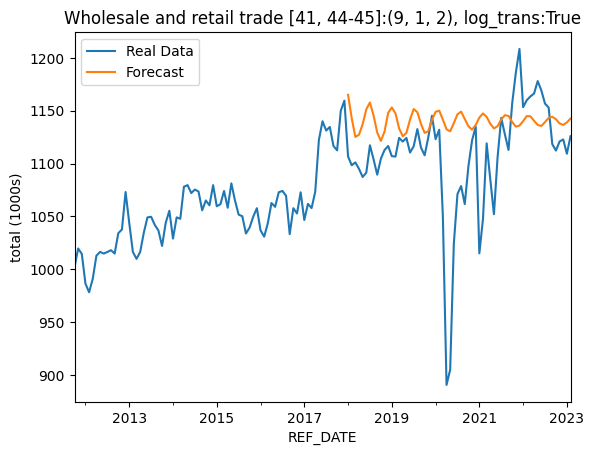

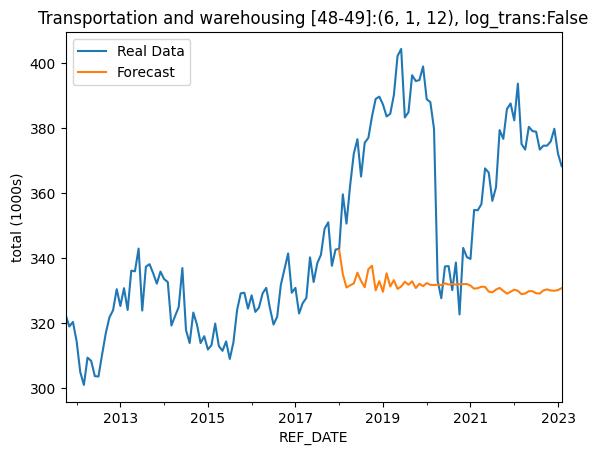

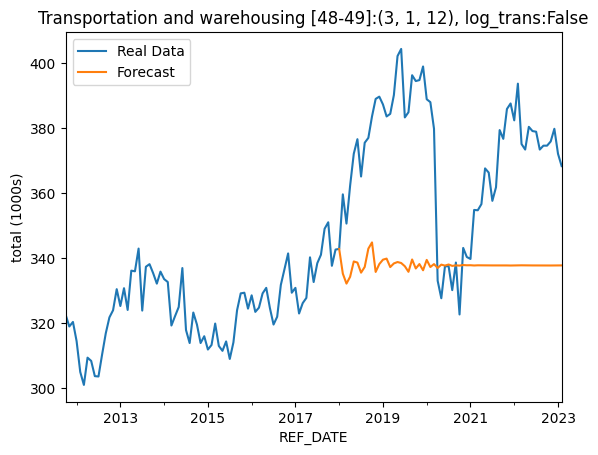

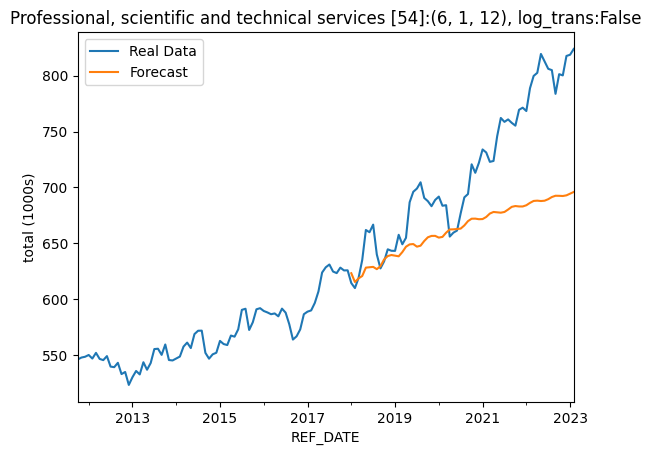

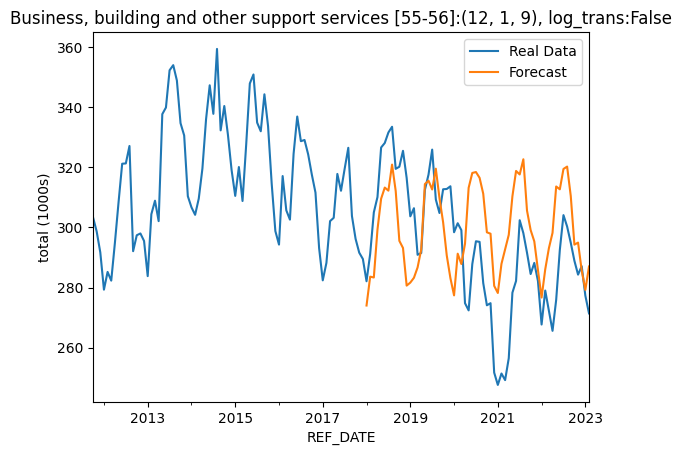

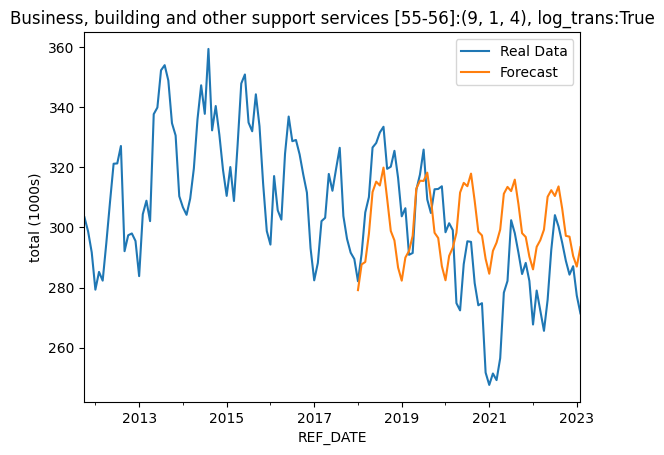

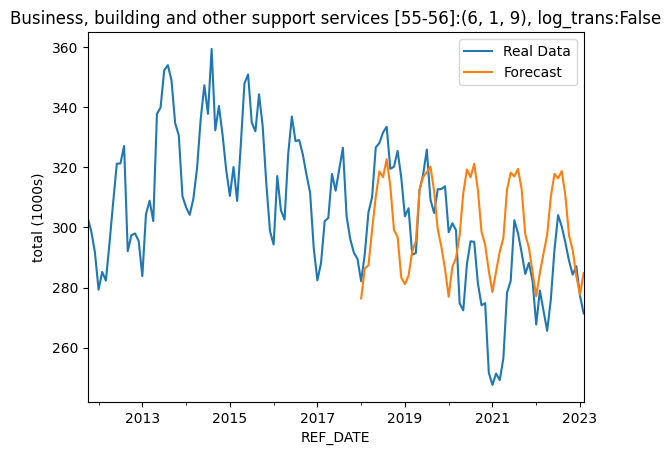

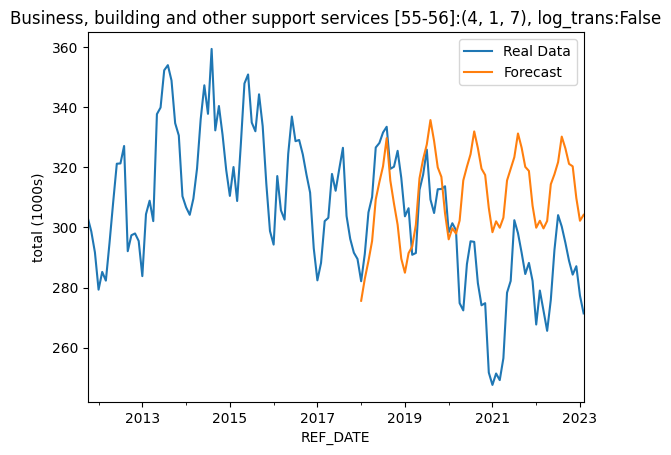

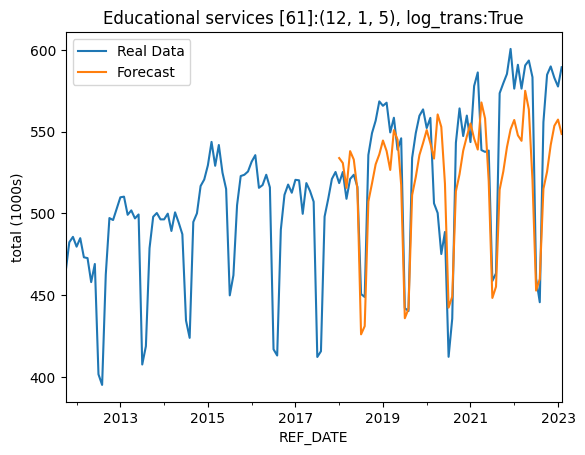

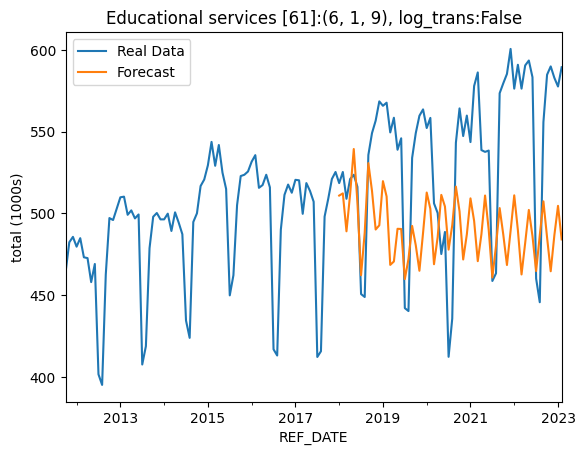

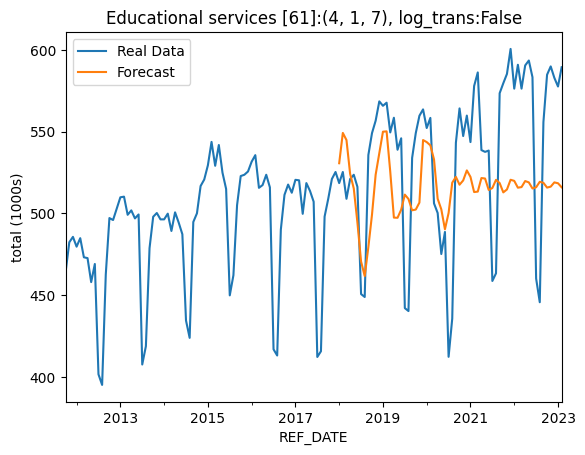

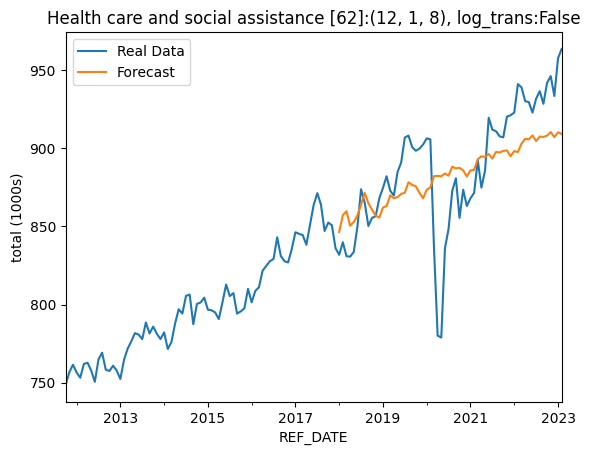

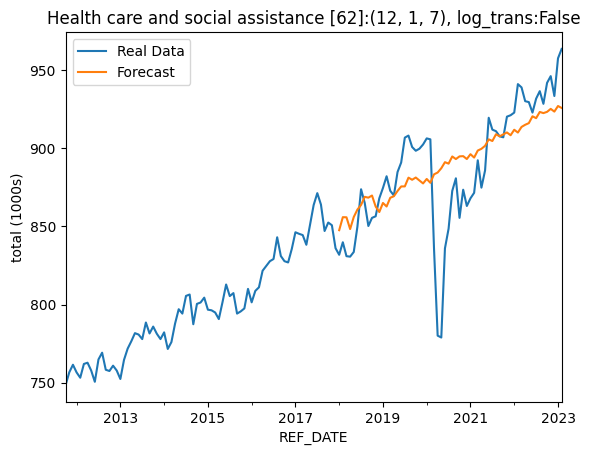

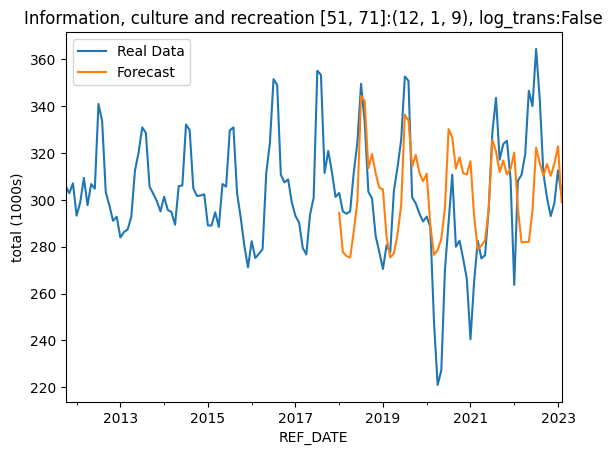

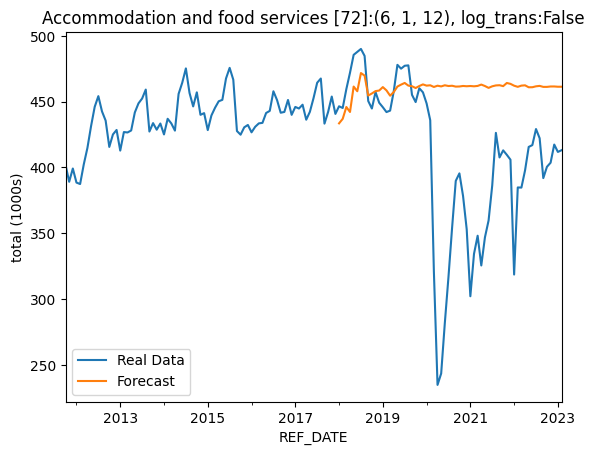

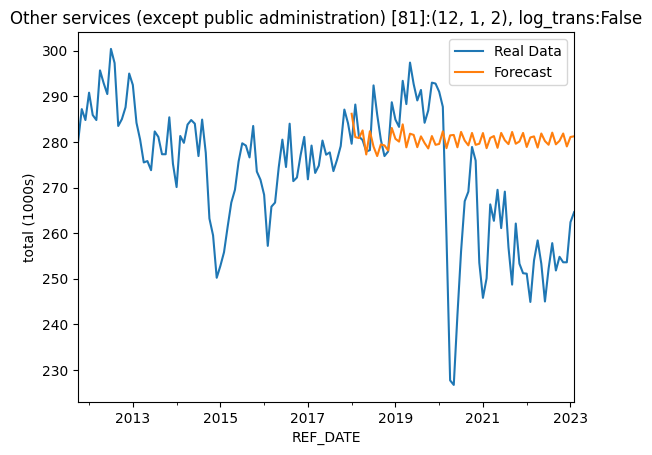

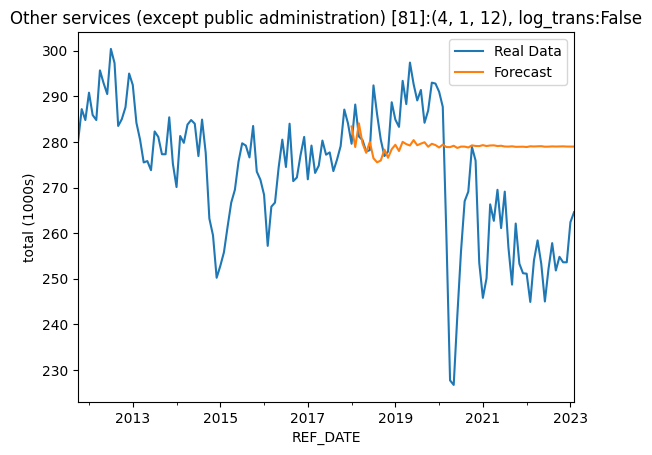

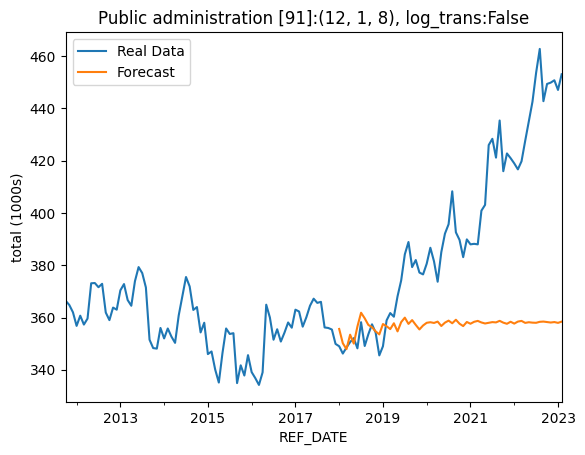

In [53]:
import warnings

# This runs the same process as above but for the individual industry segments.
# Because of the different data shapes, I tried to pick the best order values for each.

SEGMENTS_ORDER = [
    # (segment, order, log_transform)
    ('Wholesale and retail trade [41, 44-45]', (9,1,2), True),
    ('Transportation and warehousing [48-49]', (6,1,12), False),
    ('Professional, scientific and technical services [54]', (6,1,12), False),
    ('Business, building and other support services [55-56]', (4,1,7), False),
    ('Educational services [61]', (12,1,5), True),
    ('Health care and social assistance [62]', (12,1,8), False),
    ('Health care and social assistance [62]', (12,1,7), False),
    ('Information, culture and recreation [51, 71]', (12,1,9), False),
    ('Accommodation and food services [72]', (6,1,12), False),
    ('Other services (except public administration) [81]', (12,1,2), False),
    ('Public administration [91]', (12,1,8), False),
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # I know, but it's late
    for g in SEGMENTS_ORDER:
        name = g[0]
        order = g[1]
        log_trans = g[2]    
        d = {name: order}

        run(DF_PIVOT, {name: order}, split_date='2017-12-31 00:00:00', log_transform=log_trans)

